# Final Project Math 110B

## Task 1 Perform LSB
> Implement LSB, the images (orignal and secret) are of the same sizes

The ideas is from the code on the github
https://github.com/kelvins/steganography/blob/main/steganography.py

In [14]:
import numpy as np
from PIL import Image
import click
import matplotlib as mpl # import whole package
import matplotlib.pyplot as plt

In [15]:
img1=Image.open('arnat59.jpg')
img2=Image.open('art294.jpg')

In [16]:
np_img1=np.asarray(img1)
np_img2=np.asarray(img2)

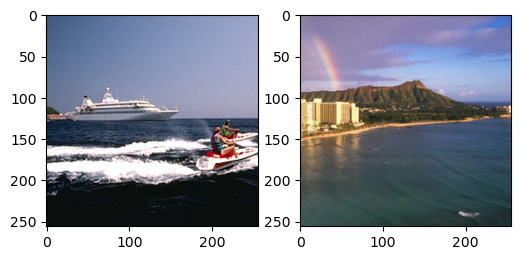

In [17]:
fig, ax = plt.subplots(ncols=2, dpi = 100)
ax[0].imshow(np_img1) # plot and set_title are the methods of ax[0] -axes
ax[1].imshow(np_img2)

In [18]:
import click
from PIL import Image


class Steganography:

    @staticmethod
    def __int_to_bin(rgb):
        """Convert an integer tuple to a binary (string) tuple.

        :param rgb: An integer tuple (e.g. (220, 110, 96))
        :return: A string tuple (e.g. ("00101010", "11101011", "00010110"))
        """
        r, g, b = rgb
        return (f'{r:08b}',
                f'{g:08b}',
                f'{b:08b}')

    @staticmethod
    def __bin_to_int(rgb):
        """Convert a binary (string) tuple to an integer tuple.

        :param rgb: A string tuple (e.g. ("00101010", "11101011", "00010110"))
        :return: Return an int tuple (e.g. (220, 110, 96))
        """
        r, g, b = rgb
        return (int(r, 2),
                int(g, 2),
                int(b, 2))

    @staticmethod
    def __merge_rgb(rgb1, rgb2):
        """Merge two RGB tuples.

        :param rgb1: A string tuple (e.g. ("00101010", "11101011", "00010110"))
        :param rgb2: Another string tuple
        (e.g. ("00101010", "11101011", "00010110"))
        :return: An integer tuple with the two RGB values merged.
        """
        r1, g1, b1 = rgb1
        r2, g2, b2 = rgb2
        rgb = (r1[:4] + r2[:4],
               g1[:4] + g2[:4],
               b1[:4] + b2[:4])
        return rgb

    @staticmethod
    def merge(img1, img2):
        """Merge two images. The second one will be merged into the first one.

        :param img1: First image
        :param img2: Second image
        :return: A new merged image.
        """

        # Check the images dimensions
        if img2.size[0] > img1.size[0] or img2.size[1] > img1.size[1]:
            raise ValueError('Image 2 should not be larger than Image 1!')

        # Get the pixel map of the two images
        pixel_map1 = img1.load()
        pixel_map2 = img2.load()

        # Create a new image that will be outputted
        new_image = Image.new(img1.mode, img1.size)
        pixels_new = new_image.load()

        for i in range(img1.size[0]):
            for j in range(img1.size[1]):
                rgb1 = Steganography.__int_to_bin(pixel_map1[i, j])

                # Use a black pixel as default
                rgb2 = Steganography.__int_to_bin((0, 0, 0))

                # Check if the pixel map position is valid for the second image
                if i < img2.size[0] and j < img2.size[1]:
                    rgb2 = Steganography.__int_to_bin(pixel_map2[i, j])

                # Merge the two pixels and convert it to a integer tuple
                rgb = Steganography.__merge_rgb(rgb1, rgb2)

                pixels_new[i, j] = Steganography.__bin_to_int(rgb)

        return new_image

    @staticmethod
    def unmerge(img):
        """Unmerge an image.

        :param img: The input image.
        :return: The unmerged/extracted image.
        """

        # Load the pixel map
        pixel_map = img.load()

        # Create the new image and load the pixel map
        new_image = Image.new(img.mode, img.size)
        pixels_new = new_image.load()

        # Tuple used to store the image original size
        original_size = img.size

        for i in range(img.size[0]):
            for j in range(img.size[1]):
                # Get the RGB (as a string tuple) from the current pixel
                r, g, b = Steganography.__int_to_bin(pixel_map[i, j])

                # Extract the last 4 bits (corresponding to the hidden image)
                # Concatenate 4 zero bits because we are working with 8 bit
                rgb = (r[4:] + '0000',
                       g[4:] + '0000',
                       b[4:] + '0000')

                # Convert it to an integer tuple
                pixels_new[i, j] = Steganography.__bin_to_int(rgb)

                # If this is a 'valid' position, store it
                # as the last valid position
                if pixels_new[i, j] != (0, 0, 0):
                    original_size = (i + 1, j + 1)

        # Crop the image based on the 'valid' pixels
        new_image = new_image.crop((0, 0, original_size[0], original_size[1]))

        return new_image

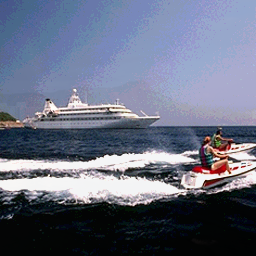

In [19]:
new_img=Steganography.merge(img1,img2)
new_img

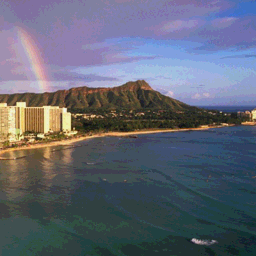

In [20]:
Steganography.unmerge(new_img)

conclusion on LSB:

the advantage of LSB is obvious. it is hard to detect the difference between two images. 
However, as Shumeet Baluja comment about LSB in his paper 'Hiding Images in Plain Sight: Deep Steganography', "statistical analysis of image and audio files can reveal whether the resultant files deviate from those that are unaltered."

it can be easily detected and decode the hidden image. and more advanced strategy would deal with how to alter the pixels wisely so that it won't be easily detected.


## Task 2

The idea is from the code: https://github.com/fpingham/DeepSteg/blob/master/DeepSteganography.ipynb

In [7]:
# Imports necessary libraries and modules
from itertools import islice
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
from torch import utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os 
import pickle
from torchvision import datasets, utils
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
from random import shuffle
from IPython.display import Image

d:\miniconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
d:\miniconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
d:\miniconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [8]:
# Hyper Parameters
num_epochs = 3
batch_size = 2
learning_rate = 0.0001
beta = 1

# Mean and std deviation of imagenet dataset. Source: http://cs231n.stanford.edu/reports/2017/pdfs/101.pdf
std = [0.229, 0.224, 0.225]
mean = [0.485, 0.456, 0.406]

# TODO: Define train, validation and models
MODELS_PATH = './models/'
TRAIN_PATH = './data/'
TEST_PATH = './test/'

if not os.path.exists(MODELS_PATH): os.mkdir(MODELS_PATH)


# Set of useful functions we are going to need

some required function:

In [9]:
def customized_loss(S_prime, C_prime, S, C, B):
    ''' Calculates loss specified on the paper.'''
    
    loss_cover = torch.nn.functional.mse_loss(C_prime, C)
    loss_secret = torch.nn.functional.mse_loss(S_prime, S)
    loss_all = loss_cover + B * loss_secret
    return loss_all, loss_cover, loss_secret

def denormalize(image, std, mean):
    ''' Denormalizes a tensor of images.'''

    for t in range(3):
        image[t, :, :] = (image[t, :, :] * std[t]) + mean[t]
    return image

def imshow(img, idx, learning_rate, beta):
    '''Prints out an image given in tensor format.'''
    
    img = denormalize(img, std, mean)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title('Example '+str(idx)+', lr='+str(learning_rate)+', B='+str(beta))
    plt.show()
    return

def gaussian(tensor, mean=0, stddev=0.1):
    '''Adds random noise to a tensor.'''
    
    noise = torch.nn.init.normal(torch.Tensor(tensor.size()), 0, 0.1)
    return Variable(tensor + noise)




In [10]:
# Preparation Network (2 conv layers)
class PrepNetwork(nn.Module):
    def __init__(self):
        super(PrepNetwork, self).__init__()
        self.initialP3 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialP4 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialP5 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalP3 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalP4 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalP5 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=5, padding=2),
            nn.ReLU())

    def forward(self, p):
        p1 = self.initialP3(p)
        p2 = self.initialP4(p)
        p3 = self.initialP5(p)
        mid = torch.cat((p1, p2, p3), 1)
        p4 = self.finalP3(mid)
        p5 = self.finalP4(mid)
        p6 = self.finalP5(mid)
        out = torch.cat((p4, p5, p6), 1)
        return out

# Hiding Network (5 conv layers)
class HidingNetwork(nn.Module):
    def __init__(self):
        super(HidingNetwork, self).__init__()
        self.initialH3 = nn.Sequential(
            nn.Conv2d(153, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialH4 = nn.Sequential(
            nn.Conv2d(153, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialH5 = nn.Sequential(
            nn.Conv2d(153, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalH3 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalH4 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalH5 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalH = nn.Sequential(
            nn.Conv2d(150, 3, kernel_size=1, padding=0))
        
    def forward(self, h):
        h1 = self.initialH3(h)
        h2 = self.initialH4(h)
        h3 = self.initialH5(h)
        mid = torch.cat((h1, h2, h3), 1)
        h4 = self.finalH3(mid)
        h5 = self.finalH4(mid)
        h6 = self.finalH5(mid)
        mid2 = torch.cat((h4, h5, h6), 1)
        out = self.finalH(mid2)
        out_noise = gaussian(out.data, 0, 0.1)
        return out, out_noise

# Reveal Network (2 conv layers)
class RevealNetwork(nn.Module):
    def __init__(self):
        super(RevealNetwork, self).__init__()
        self.initialR3 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.initialR4 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.initialR5 = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalR3 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=3, padding=1),
            nn.ReLU())
        self.finalR4 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 50, kernel_size=4, padding=2),
            nn.ReLU())
        self.finalR5 = nn.Sequential(
            nn.Conv2d(150, 50, kernel_size=5, padding=2),
            nn.ReLU())
        self.finalR = nn.Sequential(
            nn.Conv2d(150, 3, kernel_size=1, padding=0))

    def forward(self, r):
        r1 = self.initialR3(r)
        r2 = self.initialR4(r)
        r3 = self.initialR5(r)
        mid = torch.cat((r1, r2, r3), 1)
        r4 = self.finalR3(mid)
        r5 = self.finalR4(mid)
        r6 = self.finalR5(mid)
        mid2 = torch.cat((r4, r5, r6), 1)
        out = self.finalR(mid2)
        return out

# Join three networks in one module
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.m1 = PrepNetwork()
        self.m2 = HidingNetwork()
        self.m3 = RevealNetwork()

    def forward(self, secret, cover):
        x_1 = self.m1(secret)
        mid = torch.cat((x_1, cover), 1)
        x_2, x_2_noise = self.m2(mid)
        x_3 = self.m3(x_2_noise)
        return x_2, x_3

In [11]:
# Creates net object
net = Net()

In [ ]:
# We create loaders for normalized training, validation and test sets

In [12]:
# Creates training set
train_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(
        TRAIN_PATH,
        transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
        std=std)
        ])), batch_size=batch_size, num_workers=1, 
        pin_memory=True, shuffle=True, drop_last=True)

d:\miniconda3\lib\site-packages\torchvision\transforms\transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [13]:
datasets.ImageFolder(
        TEST_PATH, 
        transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
        std=std)
        ]))

Dataset ImageFolder
    Number of datapoints: 24
    Root location: ./test/
    StandardTransform
Transform: Compose(
               Scale(size=256, interpolation=bilinear)
               RandomCrop(size=(224, 224), padding=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [14]:
# Creates test set
test_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(
        TEST_PATH, 
        transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,
        std=std)
        ])), batch_size=2, num_workers=1, 
        pin_memory=True, shuffle=True, drop_last=True)
test_loader

In [17]:
# We train the model and validate it, saving the best model. We use Adam as an optimizer as the paper specifies.

def train_model(train_loader, beta, learning_rate):
    
    # Save optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    loss_history = []
    # Iterate over batches performing forward and backward passes
    for epoch in range(num_epochs):

        # Train mode
        net.train()
        
        train_losses = []
        # Train one epoch
        for idx, train_batch in enumerate(train_loader):

            data, _  = train_batch

            # Saves secret images and secret covers
            train_covers = data[:len(data)//2]
            train_secrets = data[len(data)//2:]
            
            # Creates variable from secret and cover images
            train_secrets = Variable(train_secrets, requires_grad=False)
            train_covers = Variable(train_covers, requires_grad=False)

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            train_hidden, train_output = net(train_secrets, train_covers)

            # Calculate loss and perform backprop
            train_loss, train_loss_cover, train_loss_secret = customized_loss(train_output, train_hidden, train_secrets, train_covers, beta)
            train_loss.backward()
            optimizer.step()
            
            # Saves training loss
            train_losses.append(train_loss.item())
            loss_history.append(train_loss.item())
            
            # Prints mini-batch losses
            print('Training: Batch {0}/{1}. Loss of {2:.4f}, cover loss of {3:.4f}, secret loss of {4:.4f}'.format(idx+1, len(train_loader), train_loss.item(), train_loss_cover.item(), train_loss_secret.item()))
    
        torch.save(net.state_dict(), MODELS_PATH+'Epoch N{}.pkl'.format(epoch+1))
        
        mean_train_loss = np.mean(train_losses)
    
        # Prints epoch average loss
        print ('Epoch [{0}/{1}], Average_loss: {2:.4f}'.format(
                epoch+1, num_epochs, mean_train_loss))
    
    return net, mean_train_loss, loss_history

In [18]:
net, mean_train_loss, loss_history = train_model(train_loader, beta, learning_rate)

d:\miniconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


Training: Batch 1/180. Loss of 2.4938, cover loss of 1.5970, secret loss of 0.8969
Training: Batch 2/180. Loss of 2.8746, cover loss of 1.6718, secret loss of 1.2029
Training: Batch 3/180. Loss of 2.9067, cover loss of 2.2079, secret loss of 0.6988
Training: Batch 4/180. Loss of 3.0381, cover loss of 1.5454, secret loss of 1.4927
Training: Batch 5/180. Loss of 3.2201, cover loss of 2.1587, secret loss of 1.0613
Training: Batch 6/180. Loss of 2.4049, cover loss of 1.7537, secret loss of 0.6511
Training: Batch 7/180. Loss of 3.1295, cover loss of 1.6386, secret loss of 1.4909
Training: Batch 8/180. Loss of 1.8368, cover loss of 0.6888, secret loss of 1.1480
Training: Batch 9/180. Loss of 1.6163, cover loss of 0.7552, secret loss of 0.8612
Training: Batch 10/180. Loss of 3.4224, cover loss of 2.3710, secret loss of 1.0514
Training: Batch 11/180. Loss of 3.6438, cover loss of 1.7140, secret loss of 1.9299
Training: Batch 12/180. Loss of 1.8311, cover loss of 1.1403, secret loss of 0.6908
T

Training: Batch 99/180. Loss of 1.4687, cover loss of 0.0843, secret loss of 1.3844
Training: Batch 100/180. Loss of 0.9948, cover loss of 0.1689, secret loss of 0.8259
Training: Batch 101/180. Loss of 2.4551, cover loss of 0.9529, secret loss of 1.5023
Training: Batch 102/180. Loss of 1.0260, cover loss of 0.1370, secret loss of 0.8890
Training: Batch 103/180. Loss of 2.7288, cover loss of 0.1622, secret loss of 2.5666
Training: Batch 104/180. Loss of 1.5402, cover loss of 0.0994, secret loss of 1.4408
Training: Batch 105/180. Loss of 2.2424, cover loss of 0.1206, secret loss of 2.1218
Training: Batch 106/180. Loss of 2.8877, cover loss of 0.7246, secret loss of 2.1631
Training: Batch 107/180. Loss of 0.9169, cover loss of 0.1553, secret loss of 0.7616
Training: Batch 108/180. Loss of 0.6057, cover loss of 0.0690, secret loss of 0.5367
Training: Batch 109/180. Loss of 1.2680, cover loss of 0.1417, secret loss of 1.1263
Training: Batch 110/180. Loss of 0.6325, cover loss of 0.0700, sec

Training: Batch 16/180. Loss of 1.6889, cover loss of 0.0773, secret loss of 1.6116
Training: Batch 17/180. Loss of 0.7755, cover loss of 0.0778, secret loss of 0.6977
Training: Batch 18/180. Loss of 2.6620, cover loss of 0.0261, secret loss of 2.6359
Training: Batch 19/180. Loss of 1.2980, cover loss of 0.0686, secret loss of 1.2295
Training: Batch 20/180. Loss of 1.6955, cover loss of 0.0339, secret loss of 1.6615
Training: Batch 21/180. Loss of 0.7597, cover loss of 0.2041, secret loss of 0.5556
Training: Batch 22/180. Loss of 2.3223, cover loss of 0.3278, secret loss of 1.9945
Training: Batch 23/180. Loss of 0.7004, cover loss of 0.0941, secret loss of 0.6063
Training: Batch 24/180. Loss of 0.5646, cover loss of 0.2574, secret loss of 0.3072
Training: Batch 25/180. Loss of 2.0951, cover loss of 0.0520, secret loss of 2.0431
Training: Batch 26/180. Loss of 1.9146, cover loss of 0.0756, secret loss of 1.8390
Training: Batch 27/180. Loss of 0.4091, cover loss of 0.0696, secret loss of

Training: Batch 114/180. Loss of 1.3357, cover loss of 0.0569, secret loss of 1.2787
Training: Batch 115/180. Loss of 1.6274, cover loss of 0.0346, secret loss of 1.5929
Training: Batch 116/180. Loss of 0.9037, cover loss of 0.0371, secret loss of 0.8666
Training: Batch 117/180. Loss of 1.7143, cover loss of 0.0787, secret loss of 1.6356
Training: Batch 118/180. Loss of 1.3786, cover loss of 0.0350, secret loss of 1.3436
Training: Batch 119/180. Loss of 1.0394, cover loss of 0.0678, secret loss of 0.9716
Training: Batch 120/180. Loss of 2.1389, cover loss of 0.0649, secret loss of 2.0741
Training: Batch 121/180. Loss of 1.3586, cover loss of 0.0734, secret loss of 1.2851
Training: Batch 122/180. Loss of 1.3785, cover loss of 0.0434, secret loss of 1.3351
Training: Batch 123/180. Loss of 1.0767, cover loss of 0.1154, secret loss of 0.9613
Training: Batch 124/180. Loss of 1.1375, cover loss of 0.0756, secret loss of 1.0619
Training: Batch 125/180. Loss of 1.4201, cover loss of 0.2043, se

Training: Batch 31/180. Loss of 0.6800, cover loss of 0.0440, secret loss of 0.6360
Training: Batch 32/180. Loss of 1.2370, cover loss of 0.0450, secret loss of 1.1919
Training: Batch 33/180. Loss of 1.8686, cover loss of 0.0300, secret loss of 1.8386
Training: Batch 34/180. Loss of 2.2976, cover loss of 0.0369, secret loss of 2.2607
Training: Batch 35/180. Loss of 0.4376, cover loss of 0.0492, secret loss of 0.3884
Training: Batch 36/180. Loss of 3.1146, cover loss of 0.0430, secret loss of 3.0716
Training: Batch 37/180. Loss of 2.7321, cover loss of 0.0836, secret loss of 2.6485
Training: Batch 38/180. Loss of 1.0249, cover loss of 0.0944, secret loss of 0.9306
Training: Batch 39/180. Loss of 1.9571, cover loss of 0.0613, secret loss of 1.8958
Training: Batch 40/180. Loss of 0.2544, cover loss of 0.0308, secret loss of 0.2236
Training: Batch 41/180. Loss of 0.9071, cover loss of 0.0531, secret loss of 0.8540
Training: Batch 42/180. Loss of 1.1501, cover loss of 0.0389, secret loss of

Training: Batch 129/180. Loss of 1.3251, cover loss of 0.0186, secret loss of 1.3065
Training: Batch 130/180. Loss of 0.8919, cover loss of 0.0484, secret loss of 0.8434
Training: Batch 131/180. Loss of 1.1246, cover loss of 0.1316, secret loss of 0.9930
Training: Batch 132/180. Loss of 1.0951, cover loss of 0.0554, secret loss of 1.0397
Training: Batch 133/180. Loss of 1.1329, cover loss of 0.0123, secret loss of 1.1206
Training: Batch 134/180. Loss of 0.7687, cover loss of 0.0847, secret loss of 0.6841
Training: Batch 135/180. Loss of 1.0361, cover loss of 0.0280, secret loss of 1.0080
Training: Batch 136/180. Loss of 1.2938, cover loss of 0.0429, secret loss of 1.2509
Training: Batch 137/180. Loss of 0.8246, cover loss of 0.0361, secret loss of 0.7885
Training: Batch 138/180. Loss of 1.5660, cover loss of 0.0224, secret loss of 1.5436
Training: Batch 139/180. Loss of 0.7017, cover loss of 0.0693, secret loss of 0.6324
Training: Batch 140/180. Loss of 1.5980, cover loss of 0.0157, se

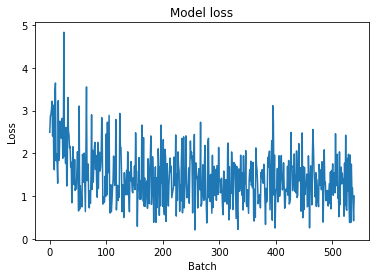

In [19]:
# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.show()

d:\miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
d:\miniconda3\lib\site-packages\ipykernel_launcher.py:21: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
d:\miniconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total loss: 1.18 
Loss on secret: 1.16 
Loss on cover: 0.02


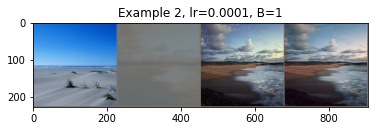

Total loss: 1.14 
Loss on secret: 1.12 
Loss on cover: 0.01


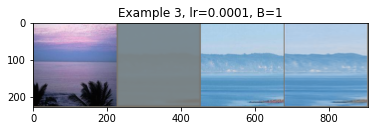

Total loss: 1.36 
Loss on secret: 1.34 
Loss on cover: 0.01


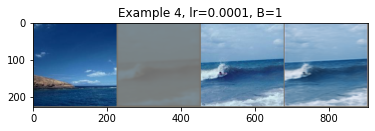

Total loss: 2.87 
Loss on secret: 2.85 
Loss on cover: 0.02


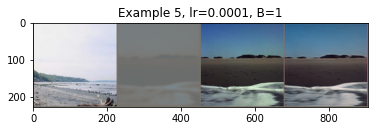

Average loss on test set: 1.22


In [20]:
# We test the model and print out a few images so we can visually see how good a job the model did.


# net.load_state_dict(torch.load(MODELS_PATH+'Epoch N4.pkl'))

# Switch to evaluate mode
net.eval()

test_losses = []
# Show images
for idx, test_batch in enumerate(test_loader):
     # Saves images
    data, _ = test_batch

    # Saves secret images and secret covers
    test_secret = data[:len(data)//2]
    test_cover = data[len(data)//2:]

    # Creates variable from secret and cover images
    test_secret = Variable(test_secret, volatile=True)
    test_cover = Variable(test_cover, volatile=True)

    # Compute output
    test_hidden, test_output = net(test_secret, test_cover)
    
    # Calculate loss
    test_loss, loss_cover, loss_secret = customized_loss(test_output, test_hidden, test_secret, test_cover, beta)
    
#     diff_S, diff_C = np.abs(np.array(test_output.data[0]) - np.array(test_secret.data[0])), np.abs(np.array(test_hidden.data[0]) - np.array(test_cover.data[0]))
    
#     print (diff_S, diff_C)
    
    if idx in [1,2,3,4]:
        print ('Total loss: {:.2f} \nLoss on secret: {:.2f} \nLoss on cover: {:.2f}'.format(test_loss.item(), loss_secret.item(), loss_cover.item()))

        # Creates img tensor
        imgs = [test_secret.data, test_output.data, test_cover.data, test_hidden.data]
        imgs_tsor = torch.cat(imgs, 0)

        # Prints Images
        imshow(utils.make_grid(imgs_tsor), idx+1, learning_rate=learning_rate, beta=beta)
        
    test_losses.append(test_loss.item())
        
mean_test_loss = np.mean(test_losses)

print ('Average loss on test set: {:.2f}'.format(mean_test_loss))

In [21]:
mean_test_loss

1.2189335102836292

### E  is the encryption function

 Forward + Backward + Optimize
 net(train_secrets, train_covers) is the E

D is the decryption function can recover sufficient information of the secret image

In [25]:
#backward
# customized_loss function is the E